In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import re
import os
import glob
import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import load_img, save_img, img_to_array, array_to_img
import keras
print(keras.backend.image_data_format())
from keras.models import Model


Using TensorFlow backend.


channels_last


In [2]:
current_path = os.getcwd()
output_path = f"{current_path}/output"
csv_path = f"{output_path}/csv"
output_train_path = f"{output_path}/train"

In [3]:
train_csv_list = glob.glob(f"{csv_path}/*_train.csv")


In [4]:
pred_csv_list=train_csv_list.pop(1)
pred_csv_list = [pred_csv_list]
print([pred_csv_list])

[['/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/20190123_train.csv']]


In [5]:
def read_csv_to_df(train_csv_list):
    columns = ["lu_x","lu_y","ru_x","ru_y","ld_x","ld_y","rd_x","rd_y"]
    return_dict = {}
    dir_list=[]
    df_concat = pd.Series([0,0,0,0,0,0,0,0],index = columns)
    for train_csv in train_csv_list:
        dir_path = train_csv.split('/')[-1].rstrip("_train.csv")
        print(train_csv)
        read_df = pd.read_csv(train_csv,index_col=0)
        df_concat = pd.concat([df_concat, read_df.T],axis=1)
        return_dict.update({dir_path:df_concat.T[1:]})
        dir_list.append(dir_path)
        df_concat = pd.Series([0,0,0,0,0,0,0,0],index = columns)
    return return_dict,dir_list

In [6]:
train_csv_dict, train_dir_list = read_csv_to_df(train_csv_list)

#test_csv_dict, test_dir_list  = read_csv_to_df(test_csv_list)
pred_csv_dict, pred_dir_list  = read_csv_to_df(pred_csv_list)

label = train_csv_dict["001"].columns

/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/002_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/004_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/001_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/003_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/20190125_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/20190124_train.csv
/home/aiclub/jupyter_env/Crimson_peacock/car_number/output/csv/20190123_train.csv


In [7]:
def data_pack(csv_dict, dir_list,train_path):
    img_shape = 200.
    x_data =[]
    y_data=[]
    data_list = []

    for name in dir_list:
        train_dir_path = f"{train_path}/{name}"

        index_list = csv_dict[name].index.values
        
        #tmp_dir = [f"{train_dir_path}/img_name" for img_name in index_list]
        data_list.extend(index_list)


        x_list = [img_to_array(load_img(f"{train_dir_path}/train_{val}.jpg"))/255. for val in index_list]
        y_list = [csv_dict[name].loc[val].values/img_shape for val in index_list]

        print(name)
        x_list = np.array(x_list)
        print(x_list.shape)
        y_list = np.array(y_list)
        print(y_list.shape)
        
        x_data.append(x_list)
        y_data.append(y_list)
        
        #return x_data, y_data
    return np.vstack(x_data), np.vstack(y_data),data_list

In [8]:
x_train,y_train,train_data_list=data_pack(train_csv_dict, train_dir_list, output_train_path)
print("==============-")
pred_x_test,pred_y_test,pred_data_list=data_pack(pred_csv_dict, pred_dir_list,output_train_path)

002
(71, 200, 200, 3)
(71, 8)
004
(348, 200, 200, 3)
(348, 8)
001
(302, 200, 200, 3)
(302, 8)
003
(157, 200, 200, 3)
(157, 8)
20190125
(34, 200, 200, 3)
(34, 8)
20190124
(27, 200, 200, 3)
(27, 8)
==============-
20190123
(128, 200, 200, 3)
(128, 8)


In [13]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPool2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.utils import plot_model

In [14]:
model = Sequential()

print(x_train.shape[1:])
model.add(Activation('relu'))
model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, (1, 1), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3) ,padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(256, (1, 1) ,padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(256, (1, 1), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(Conv2D(512, (3, 3), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (1, 1), padding='same',kernel_initializer='he_normal'))
model.add(BatchNormalization())
#model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(y_train.shape[1]))
#model.add(Activation('softmax'))

(200, 200, 3)


In [17]:
from keras.optimizers import Adam
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(loss='mean_squared_error',
                  optimizer=adam,
                  metrics=['acc'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=128, epochs=300, verbose=1, validation_split=0.1)

Train on 845 samples, validate on 94 samples
Epoch 1/300
845/845 [==============================] - 87s 103ms/step - loss: 2.5403 - acc: 0.1432 - val_loss: 0.3141 - val_acc: 0.3085
Epoch 2/300
845/845 [==============================] - 86s 102ms/step - loss: 2.1091 - acc: 0.1089 - val_loss: 0.2040 - val_acc: 0.1383
Epoch 3/300
845/845 [==============================] - 87s 103ms/step - loss: 1.8446 - acc: 0.1479 - val_loss: 0.3097 - val_acc: 0.1489
Epoch 4/300
845/845 [==============================] - 87s 102ms/step - loss: 1.6588 - acc: 0.1574 - val_loss: 0.3096 - val_acc: 0.0106
Epoch 5/300
845/845 [==============================] - 87s 103ms/step - loss: 1.5031 - acc: 0.1231 - val_loss: 0.2753 - val_acc: 0.0106
Epoch 6/300
845/845 [==============================] - 87s 102ms/step - loss: 1.3816 - acc: 0.1219 - val_loss: 0.1767 - val_acc: 0.2128
Epoch 7/300
845/845 [==============================] - 87s 103ms/step - loss: 1.1872 - acc: 0.1586 - val_loss: 0.1607 - val_acc: 0.2128
Epo

845/845 [==============================] - 87s 103ms/step - loss: 0.0977 - acc: 0.2556 - val_loss: 0.0483 - val_acc: 0.2128
Epoch 61/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0955 - acc: 0.2604 - val_loss: 0.0397 - val_acc: 0.5319
Epoch 62/300
845/845 [==============================] - 87s 102ms/step - loss: 0.0882 - acc: 0.2722 - val_loss: 0.0473 - val_acc: 0.5319
Epoch 63/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0926 - acc: 0.2675 - val_loss: 0.0454 - val_acc: 0.2128
Epoch 64/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0940 - acc: 0.2627 - val_loss: 0.0430 - val_acc: 0.2128
Epoch 65/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0848 - acc: 0.2757 - val_loss: 0.0390 - val_acc: 0.5319
Epoch 66/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0840 - acc: 0.2959 - val_loss: 0.0436 - val_acc: 0.2128
Epoch 67/300
845/845 [==============================] 

Epoch 120/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0385 - acc: 0.4118 - val_loss: 0.0397 - val_acc: 0.2021
Epoch 121/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0386 - acc: 0.4107 - val_loss: 0.0302 - val_acc: 0.2128
Epoch 122/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0366 - acc: 0.4047 - val_loss: 0.0316 - val_acc: 0.6064
Epoch 123/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0376 - acc: 0.3953 - val_loss: 0.0380 - val_acc: 0.5851
Epoch 124/300
845/845 [==============================] - 87s 102ms/step - loss: 0.0360 - acc: 0.4272 - val_loss: 0.0353 - val_acc: 0.2766
Epoch 125/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0335 - acc: 0.4083 - val_loss: 0.0337 - val_acc: 0.2128
Epoch 126/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0333 - acc: 0.4154 - val_loss: 0.0319 - val_acc: 0.2128
Epoch 127/300
845/845 [===========

845/845 [==============================] - 87s 103ms/step - loss: 0.0222 - acc: 0.5325 - val_loss: 0.0629 - val_acc: 0.5319
Epoch 180/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0224 - acc: 0.5503 - val_loss: 0.0404 - val_acc: 0.5745
Epoch 181/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0230 - acc: 0.5077 - val_loss: 0.0403 - val_acc: 0.4255
Epoch 182/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0221 - acc: 0.5669 - val_loss: 0.0406 - val_acc: 0.5532
Epoch 183/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0223 - acc: 0.5254 - val_loss: 0.0542 - val_acc: 0.5000
Epoch 184/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0218 - acc: 0.5467 - val_loss: 0.0533 - val_acc: 0.5213
Epoch 185/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0225 - acc: 0.5432 - val_loss: 0.0578 - val_acc: 0.4894
Epoch 186/300
845/845 [=========================

845/845 [==============================] - 87s 103ms/step - loss: 0.0186 - acc: 0.5574 - val_loss: 0.0362 - val_acc: 0.5532
Epoch 239/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0185 - acc: 0.5692 - val_loss: 0.0477 - val_acc: 0.5000
Epoch 240/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0179 - acc: 0.5538 - val_loss: 0.0269 - val_acc: 0.5426
Epoch 241/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0181 - acc: 0.5420 - val_loss: 0.0256 - val_acc: 0.5851
Epoch 242/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0182 - acc: 0.5302 - val_loss: 0.0256 - val_acc: 0.5426
Epoch 243/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0179 - acc: 0.5574 - val_loss: 0.0381 - val_acc: 0.5745
Epoch 244/300
845/845 [==============================] - 87s 103ms/step - loss: 0.0178 - acc: 0.5408 - val_loss: 0.0313 - val_acc: 0.5213
Epoch 245/300
845/845 [=========================

In [ ]:
model.save(f"{output_path}/test.h5")
#plot_model(model, to_file=f"{output_path}/test.png")

In [ ]:
from keras.models import load_model
l_mode=load_model(f"{output_path}/test.h5")

In [ ]:
score = l_mode.evaluate(pred_x_test, pred_y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
l_mode.summary()

In [22]:
pred_his = l_mode.predict(pred_x_test)
print(pred_his)

NameError: name 'l_mode' is not defined

In [23]:
print(pred_x_test.shape)

(128, 200, 200, 3)


In [24]:
def check_img(image, y_label,name=None):
    im = image

    cv2.drawMarker(im,(int(y_label[0]),int(y_label[1])),(255,0,0), markerType=cv2.MARKER_STAR)
    cv2.drawMarker(im,(int(y_label[2]),int(y_label[3])),(0,255,0), markerType=cv2.MARKER_STAR)
    cv2.drawMarker(im,(int(y_label[4]),int(y_label[5])),(0,0,255), markerType=cv2.MARKER_STAR)
    cv2.drawMarker(im,(int(y_label[6]),int(y_label[7])),(0,0,0), markerType=cv2.MARKER_STAR)
    
    if name is not None:
        image_path =f"{current_path}/output/model/{name}.jpg"
        cv2.imwrite(image_path,im)
        return im
    else:
        return im
    del im

In [25]:
print((pred_x_test[0]*255).astype(np.int16))

[[[ 45  48  53]
  [ 47  50  55]
  [ 50  53  58]
  ...
  [178 202 228]
  [177 201 227]
  [176 200 226]]

 [[ 36  41  45]
  [ 38  43  47]
  [ 40  45  49]
  ...
  [178 202 228]
  [177 201 227]
  [176 200 226]]

 [[  0   1   5]
  [  0   1   7]
  [  0   4  10]
  ...
  [179 203 229]
  [178 202 228]
  [177 201 227]]

 ...

 [[ 91  87  84]
  [103  99  96]
  [109 105 102]
  ...
  [ 30  36  50]
  [ 31  37  51]
  [ 32  38  52]]

 [[105 101  98]
  [ 99  95  92]
  [100  96  93]
  ...
  [ 30  36  50]
  [ 31  37  51]
  [ 32  38  52]]

 [[ 79  75  72]
  [ 77  73  70]
  [ 96  92  89]
  ...
  [ 27  33  47]
  [ 29  35  49]
  [ 30  36  50]]]


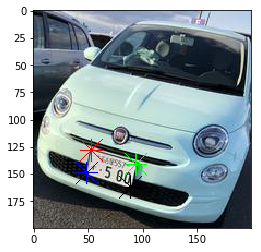

In [26]:
image=check_img((pred_x_test[0]*255).astype(np.int16),pred_y_test[0]*200)
plt.imshow(image)
test_img_path =f"{current_path}/output/model/test_img.jpg"
plt.savefig(test_img_path)

In [23]:
print(pred_y_test[0])

[0.26805623 0.64382872 0.47018905 0.70579345 0.24769753 0.74861461
 0.44740669 0.81360202]


In [24]:
for i,name in enumerate(pred_data_list):
    x_img = (pred_x_test[i]*255).astype(np.int16)
    pred_val = (pred_his[i]*200).astype(np.int16)
    check_img(x_img,pred_val,name)